# Experiments Using BLRHS to Analyze BART Ridership Dataset

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lrhs.blrhs import cp_vb, cp_vb_batch, tucker_vb, tucker_vb_batch
from lrhs.blrhs import load_json, load_pickle, get_timestamp, axis_except
from lrhs.blrhs import set_fonts, argsort_ascending_2d, plot_weekly_patterns
from lrhs.blrhs import plot_bart_latents_through_seasons, plot_elbo
import gzip

%matplotlib inline
set_fonts(15, 18)
stations_map = load_json("data/bart/bart_station_map.json")
stations_inv_map = {value: key for key, value in stations_map.items()}

The dataset in these experiments are based on the dataset from BART administration: https://www.bart.gov/about/reports/ridership. We provide a version of the dataset where we create the tensor that holds the data necessary for experimentation. Note that throughout this notebook, data tensor dimension orders at times are different than from the main paper due to practical reasons. This is addressed by always explicitly referring to the said dimensions and does not affect the inference results in any way.

## Examine Existing Results

We now load the model, results of which were featured in the main paper. When loading the factors from saved model we load so as to be consistent with the notation in the paper, with the addition that we use $M$ instead of $\widehat{\mathbf{M}}$ within the code for brevity, and use variable names instead of $1,2, \dots$ for seasonality factors.

In [3]:
results = load_pickle("models/bart_model.pkl")
elbo, log_Ms = results["elbo"], results["thetas"]
lam, G, I_origin, I_destination, K_year, M_week, M_day, M_hour = [jnp.exp(log_M) for log_M in log_Ms]
# The core tensor (normalizing to ensure interpretability as probability table).
G = G / G.sum()
# Factor matrices (normalizing to ensure interpretability as conditional probability tables).
I_origin, I_destination, K_year, M_week, M_day, M_hour = [
    arr/arr.sum(0, keepdims=True) for arr in [I_origin, I_destination, K_year, M_week, M_day, M_hour]
    ]

Checking for the convergence of VI.

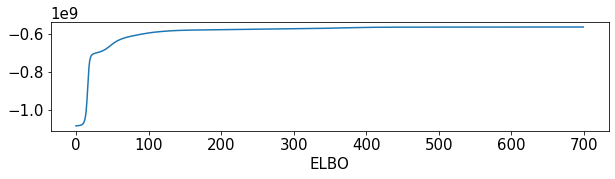

In [4]:
plot_elbo(elbo)

Examining day and hour latent factors.

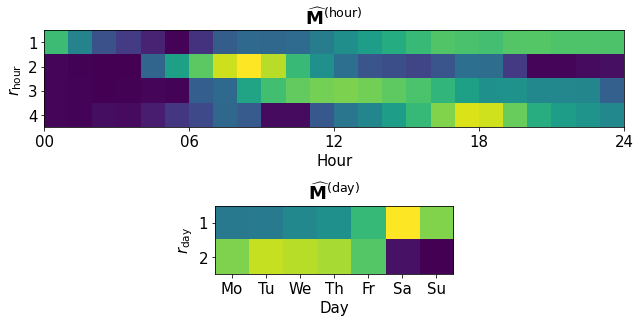

In [5]:
fig, axes = plt.subplots(2,1,figsize=(9,5),gridspec_kw={"height_ratios":[3, 1]})

axes[0].imshow(M_hour.T**0.25) # The exponent for better visualization.
axes[0].set_yticks([0,1,2,3]); axes[0].set_yticklabels([1,2,3,4])
axes[0].set_ylabel("$r_{\mathrm{hour}}$"); axes[0].set_xlabel("Hour")
axes[0].set_xticks([-0.5, 5.5, 11.5, 17.5, 23.5]); axes[0].set_xticklabels(["00", "06", "12", "18", "24"])
axes[0].set_title("$\widehat{\mathbf{M}}^{(\mathrm{hour})}$")

axes[1].imshow(M_day.T)
axes[1].set_yticks([0,1]); axes[1].set_yticklabels([1,2])
axes[1].set_xlabel("Day"); axes[1].set_xticks(range(7))
axes[1].set_xticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]); axes[1].set_ylabel("$r_{\mathrm{day}}$")
axes[1].set_title("$\widehat{\mathbf{M}}^{(\mathrm{day})}$")
fig.tight_layout()

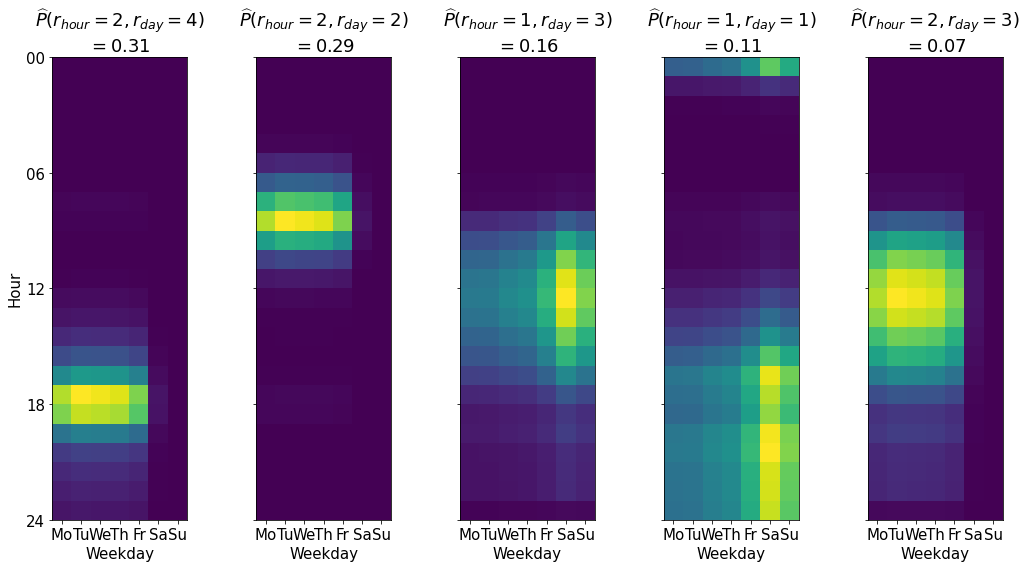

In [6]:
P_GDH = jnp.einsum("ab, ia, jb -> abij", G.sum(axis=(0,1, 2,3)), M_day, M_hour)
idxs, values = argsort_ascending_2d(G.sum(axis=axis_except([4,5], 6)))
num_patterns = 5
plot_weekly_patterns(P_GDH, idxs[:num_patterns], values[:num_patterns], figsize=(8,7), filepath="week_latents.pdf")

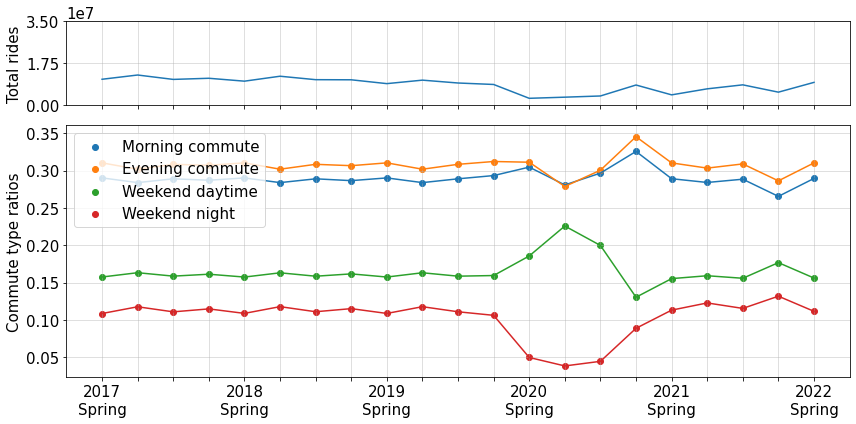

In [7]:
P_RYWDH = jnp.einsum("abcd, ia, jb, kc, ld -> abcdijkl", G.sum(axis=(0,1)), M_year, M_week, M_day, M_hour)
X_temporal = np.load("data/bart/bart_2011_2022_temporal.npy") # A version of the data summed across all routes.
_ = plot_bart_latents_through_seasons(X_temporal, P_RYWDH, start_year=2017, return_results=False)

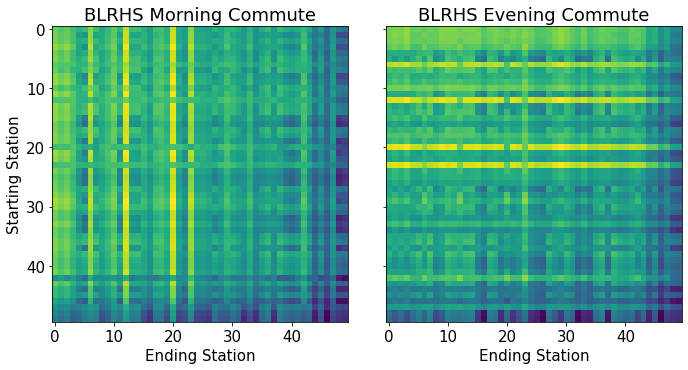

In [8]:
P_RSER = jnp.einsum("abcd, ia, jb -> abcdij", G.sum(axis=(2,3)), M_origin, M_destination)
fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
axes[0].imshow(jnp.log(P_RSER[:, :, 1, 1, :, :].sum(axis=(0,1)))) # for easier visualization
axes[0].set_ylabel("Starting Station")
axes[0].set_xlabel("Ending Station")
axes[0].set_title("BLRHS Morning Commute")
axes[1].imshow(jnp.log(P_RSER[:, :, 1, 3, :, :].sum(axis=(0,1)))) # for easier visualization
axes[1].set_title("BLRHS Evening Commute")
axes[1].set_xlabel("Ending Station")
plt.tight_layout()

## Training BLRHS

We present a training run with a version of the data that includes 4 busiest stations (EMBR, MONT, POWL, CIVC). In the full BART dataset we have a tensor of size $50 \times 50 \times 12 \times 53 \times 7 \times 24$. In the 4 stations version loaded below, this is $5\times 5\times 12 \times 53 \times 7 \times 24$. You can download the full data tensor at this link: https://drive.google.com/file/d/1rnd6l598wy_K0przhNTMvttylBpq5mqt/view?usp=sharing, which you can use with the methods below. Note that the variable orders in the data are slightly different than in the paper, with no implications to the methodology and results.

### Recommendations when training with very large data
When training with very large tensors, the memory required by the computations might exceed the memory available, especially when training with BLRHS-T. If you encounter this problem, here are our suggestions:
- Prefer `cp_vb_batch`, `tucker_vb_batch` instead of `cp_vb`, `tucker_vb`, and increase num_batches parameter as needed. Batch versions are implemented specifically for this purpose.
- Force JAX to use CPU instead of GPU, which would use the computer RAM instead of GPU RAM, at the cost of a slow down. The command for this is: `import os; os.environ["JAX_PLATFORM_NAME"] = "cpu"`

In [3]:
f = gzip.GzipFile("data/bart/bart_2011_2022_4_stations.npy.gz", "r")
X = np.load(file=f)
f.close()

### Example run with BLRHS-Tucker:

In [8]:
print_freq = 100 # Set to 0 if non-verbose training is desired.
a = 1000.0
R = [2, 2, 2, 3, 2, 4]
seed = 0
num_epochs = 500
elbo, log_Ms = tucker_vb_batch(X, R=R, a=a, num_epochs=num_epochs, print_freq=print_freq, num_batches=5, seed=seed)

Epoch: 100, ELBO: -6612094
Epoch: 200, ELBO: -6098609
Epoch: 300, ELBO: -6025084
Epoch: 400, ELBO: -6008781
Epoch: 500, ELBO: -6001446


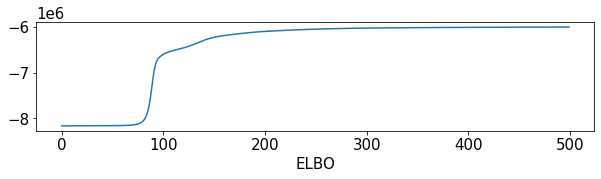

In [10]:
plot_elbo(elbo)

In [11]:
lam, G, I_origin, I_destination, K_year, M_week, M_day, M_hour = [jnp.exp(log_M) for log_M in log_Ms]
G = G / G.sum()
# Factor matrices (normalizing to ensure interpretability as conditional probability tables).
I_origin, I_destination, K_year, M_week, M_day, M_hour = [
    arr/arr.sum(0, keepdims=True) for arr in [I_origin, I_destination, K_year, M_week, M_day, M_hour]
    ]

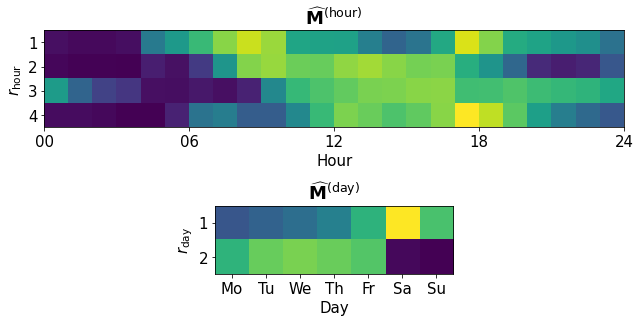

In [12]:
fig, axes = plt.subplots(2,1,figsize=(9,5),gridspec_kw={"height_ratios":[3, 1]})

axes[0].imshow(M_hour.T**0.25) # The exponent for better visualization.
axes[0].set_yticks([0,1,2,3]); axes[0].set_yticklabels([1,2,3,4])
axes[0].set_ylabel("$r_{\mathrm{hour}}$"); axes[0].set_xlabel("Hour")
axes[0].set_xticks([-0.5, 5.5, 11.5, 17.5, 23.5]); axes[0].set_xticklabels(["00", "06", "12", "18", "24"])
axes[0].set_title("$\widehat{\mathbf{M}}^{(\mathrm{hour})}$")

axes[1].imshow(M_day.T)
axes[1].set_yticks([0,1]); axes[1].set_yticklabels([1,2])
axes[1].set_xlabel("Day"); axes[1].set_xticks(range(7))
axes[1].set_xticklabels(["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]); axes[1].set_ylabel("$r_{\mathrm{day}}$")
axes[1].set_title("$\widehat{\mathbf{M}}^{(\mathrm{day})}$")
fig.tight_layout()

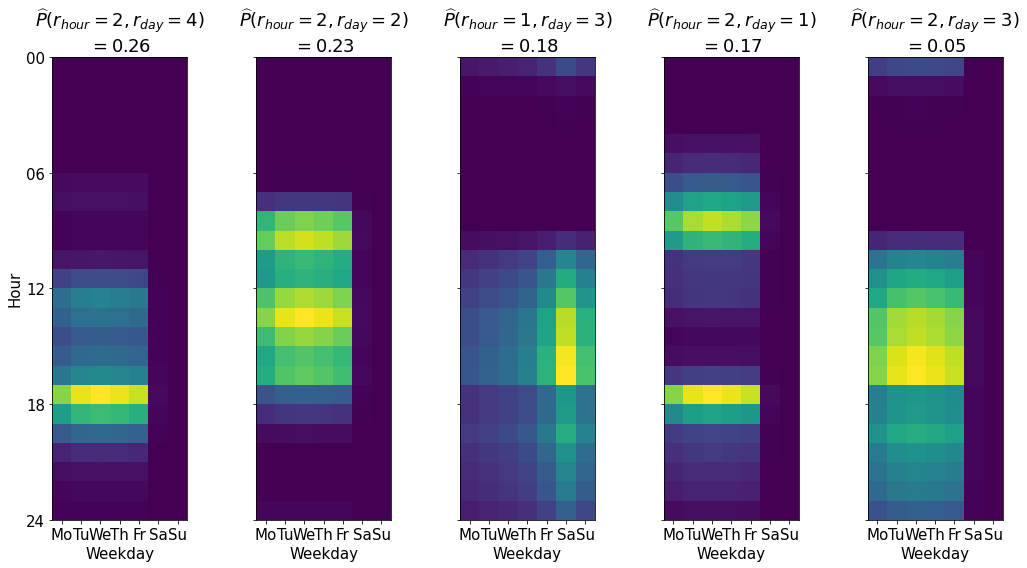

In [13]:
P_GDH = jnp.einsum("ab, ia, jb -> abij", G.sum(axis=(0,1, 2,3)), M_day, M_hour)
idxs, values = argsort_ascending_2d(G.sum(axis=axis_except([4,5], 6)))
num_patterns = 5
plot_weekly_patterns(P_GDH, idxs[:num_patterns], values[:num_patterns], figsize=(8,7), filepath="week_latents.pdf")

### Example run with BLRHS-CP

In [4]:
print_freq = 100 # Set to 0 if non-verbose training is desired.
a = 1000.0
R = 20
seed = 0
num_epochs = 500
elbo, log_Ms = cp_vb(X, R=R, a=a, num_epochs=num_epochs, print_freq=print_freq, seed=seed)

Epoch: 100, ELBO: -4337160
Epoch: 200, ELBO: -4280778
Epoch: 300, ELBO: -4262504
Epoch: 400, ELBO: -4256228
Epoch: 500, ELBO: -4250175


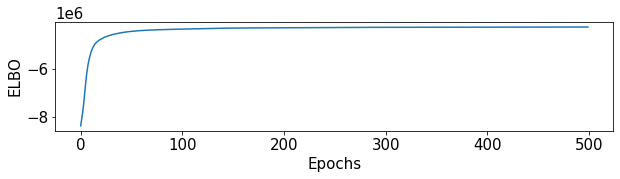

In [5]:
plot_elbo(elbo)

In [6]:
lam, G, I_origin, I_destination, K_year, M_week, M_day, M_hour = [jnp.exp(log_M) for log_M in log_Ms]
G = G / G.sum()
# Factor matrices (normalizing to ensure interpretability as conditional probability tables).
I_origin, I_destination, K_year, M_week, M_day, M_hour = [
    arr/arr.sum(0, keepdims=True) for arr in [I_origin, I_destination, K_year, M_week, M_day, M_hour]
    ]

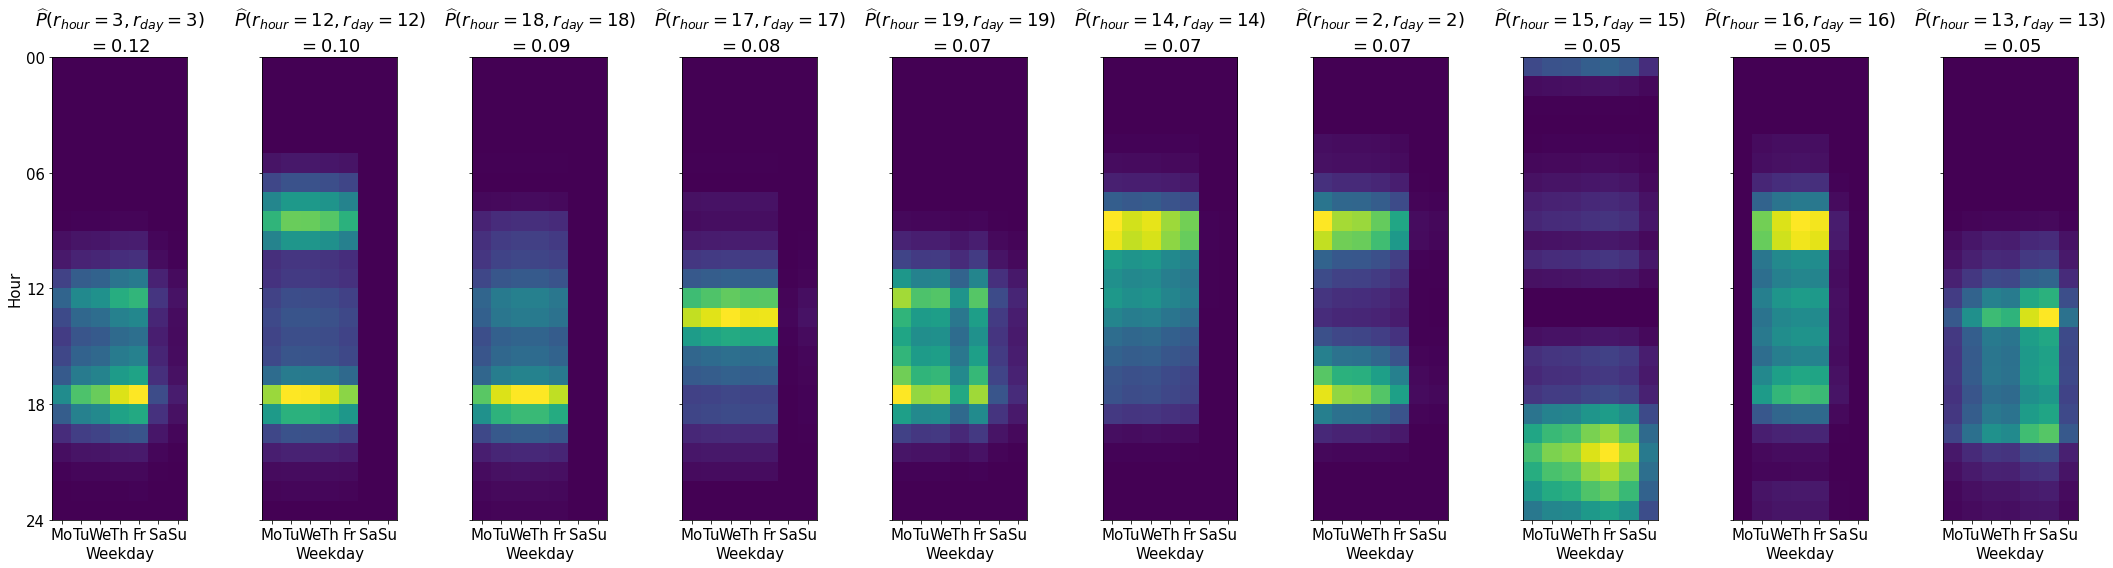

In [14]:
P_GDH = jnp.einsum("a, ia, ja -> aij", G, M_day, M_hour) # Notice the difference of the einsum compared to Tucker decomposition.
idxs, values = np.flip(np.argsort(G)), np.flip(np.sort(G))
num_patterns = 10
plot_weekly_patterns(P_GDH, idxs[:num_patterns, np.newaxis], values[:num_patterns], figsize=(8,7), filepath="week_latents.pdf")